# News popularity prediction

# Introduction
The dataset we are using is from the UCI Machine Learning Repository and is titled “Online News Popularity”. This dataset was compiled from articles shared by Mashable, a popular news website, over a period of two years from January 8th, 2013 to January 7th, 2015. The dataset includes a total of 39,644 articles and 61 different features. These features include the number of shares, the number of reactions, the number of comments, and keywords associated with the article, as well as various metrics such as the number of clicks, the number of shares, the number of comments, and the rate at which the article was shared. Additionally, the dataset includes the title and the text of the article, as well as the URL of the article.

The purpose of this dataset is to analyze the factors that influence the popularity of an online article. By looking at the features associated with each article, it is possible to gain insight into what makes a story more likely to be shared, commented on, and liked. This dataset can be used to build and analyze predictive models that can accurately predict the popularity of an article based on certain features and characteristics. Furthermore, this dataset can help provide insights into the current trends in online news and how people respond to particular stories.

# Objectives

Predicting the popularity of different news articles using it's features.

# Outline
1. Importing the libraries we need
2. Setting up BigQuery
3. Performing a basic exploratory data analysis
4. Preprocessing our data
5. Predictive modelling
6. Takeaways

# Importing the libraries needed

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.ensemble import RandomForestRegressor, IsolationForest, RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel


In [2]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

# BigQuery setup

1. Create a project in the Google Cloud Platform: First, you need to create a project in the Google Cloud Platform. You can create a project by going to the Google Cloud Console and clicking the “Select a project” dropdown in the top bar.

2. Create Credentials: After creating a project, you’ll need to create credentials to be used with the BigQuery API. In the Google Cloud Console, navigate to the “APIs & Services” tab and click “Credentials”. Select “Create credentials” and then select “Service account key”.

3. Create a Client: Once you have your credentials, you can create a client in Python to connect to the BigQuery API. To do this, you’ll need to first install the Google Cloud Client library for Python. Then, use the credentials you created earlier to instantiate the BigQuery client.

In [3]:
credentials = service_account.Credentials.from_service_account_file(
'/Users/ali/Downloads/aiapplications-ae5bffeac94b.json')
project_id = 'aiapplications'

In [4]:
client = bigquery.Client(credentials= credentials, project=project_id)

# Exploratory data analysis

## Query the data

Querying data from BigQuery using Python is relatively straightforward. First, you must set up a connection between Python and BigQuery using the google.cloud library. Once the connection is established, you can use the query() function to run SQL commands on the BigQuery database. This function returns a BigQuery job object, which can then be used to get the query results. Additionally, you can use the BigQuery Storage API to read the query results directly into a pandas DataFrame, which is useful for further data analysis. With the right setup, you can easily and quickly query data from BigQuery using Python.

In [5]:
query_job = client.query("""
SELECT * 
FROM `aiapplications.ClassData.online_news_popularity`
""")

results = query_job.result() # Wait for the job to complete.


df = results.to_dataframe()

## Getting to know the dataset

In [6]:
df.columns

Index(['url', '_timedelta', '_n_tokens_title', '_n_tokens_content',
       '_n_unique_tokens', '_n_non_stop_words', '_n_non_stop_unique_tokens',
       '_num_hrefs', '_num_self_hrefs', '_num_imgs', '_num_videos',
       '_average_token_length', '_num_keywords', '_data_channel_is_lifestyle',
       '_data_channel_is_entertainment', '_data_channel_is_bus',
       '_data_channel_is_socmed', '_data_channel_is_tech',
       '_data_channel_is_world', '_kw_min_min', '_kw_max_min', '_kw_avg_min',
       '_kw_min_max', '_kw_max_max', '_kw_avg_max', '_kw_min_avg',
       '_kw_max_avg', '_kw_avg_avg', '_self_reference_min_shares',
       '_self_reference_max_shares', '_self_reference_avg_sharess',
       '_weekday_is_monday', '_weekday_is_tuesday', '_weekday_is_wednesday',
       '_weekday_is_thursday', '_weekday_is_friday', '_weekday_is_saturday',
       '_weekday_is_sunday', '_is_weekend', '_LDA_00', '_LDA_01', '_LDA_02',
       '_LDA_03', '_LDA_04', '_global_subjectivity',
       '_global_sent

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1   _timedelta                      39644 non-null  float64
 2   _n_tokens_title                 39644 non-null  float64
 3   _n_tokens_content               39644 non-null  float64
 4   _n_unique_tokens                39644 non-null  float64
 5   _n_non_stop_words               39644 non-null  float64
 6   _n_non_stop_unique_tokens       39644 non-null  float64
 7   _num_hrefs                      39644 non-null  float64
 8   _num_self_hrefs                 39644 non-null  float64
 9   _num_imgs                       39644 non-null  float64
 10  _num_videos                     39644 non-null  float64
 11  _average_token_length           39644 non-null  float64
 12  _num_keywords                   

In [8]:
df.describe()

,_timedelta,_n_tokens_title,_n_tokens_content,_n_unique_tokens,_n_non_stop_words,_n_non_stop_unique_tokens,_num_hrefs,_num_self_hrefs,_num_imgs,_num_videos,...,_min_positive_polarity,_max_positive_polarity,_avg_negative_polarity,_min_negative_polarity,_max_negative_polarity,_title_subjectivity,_title_sentiment_polarity,_abs_title_subjectivity,_abs_title_sentiment_polarity,_shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


Distribution of different features in comparison with the target variable is illustrated below.

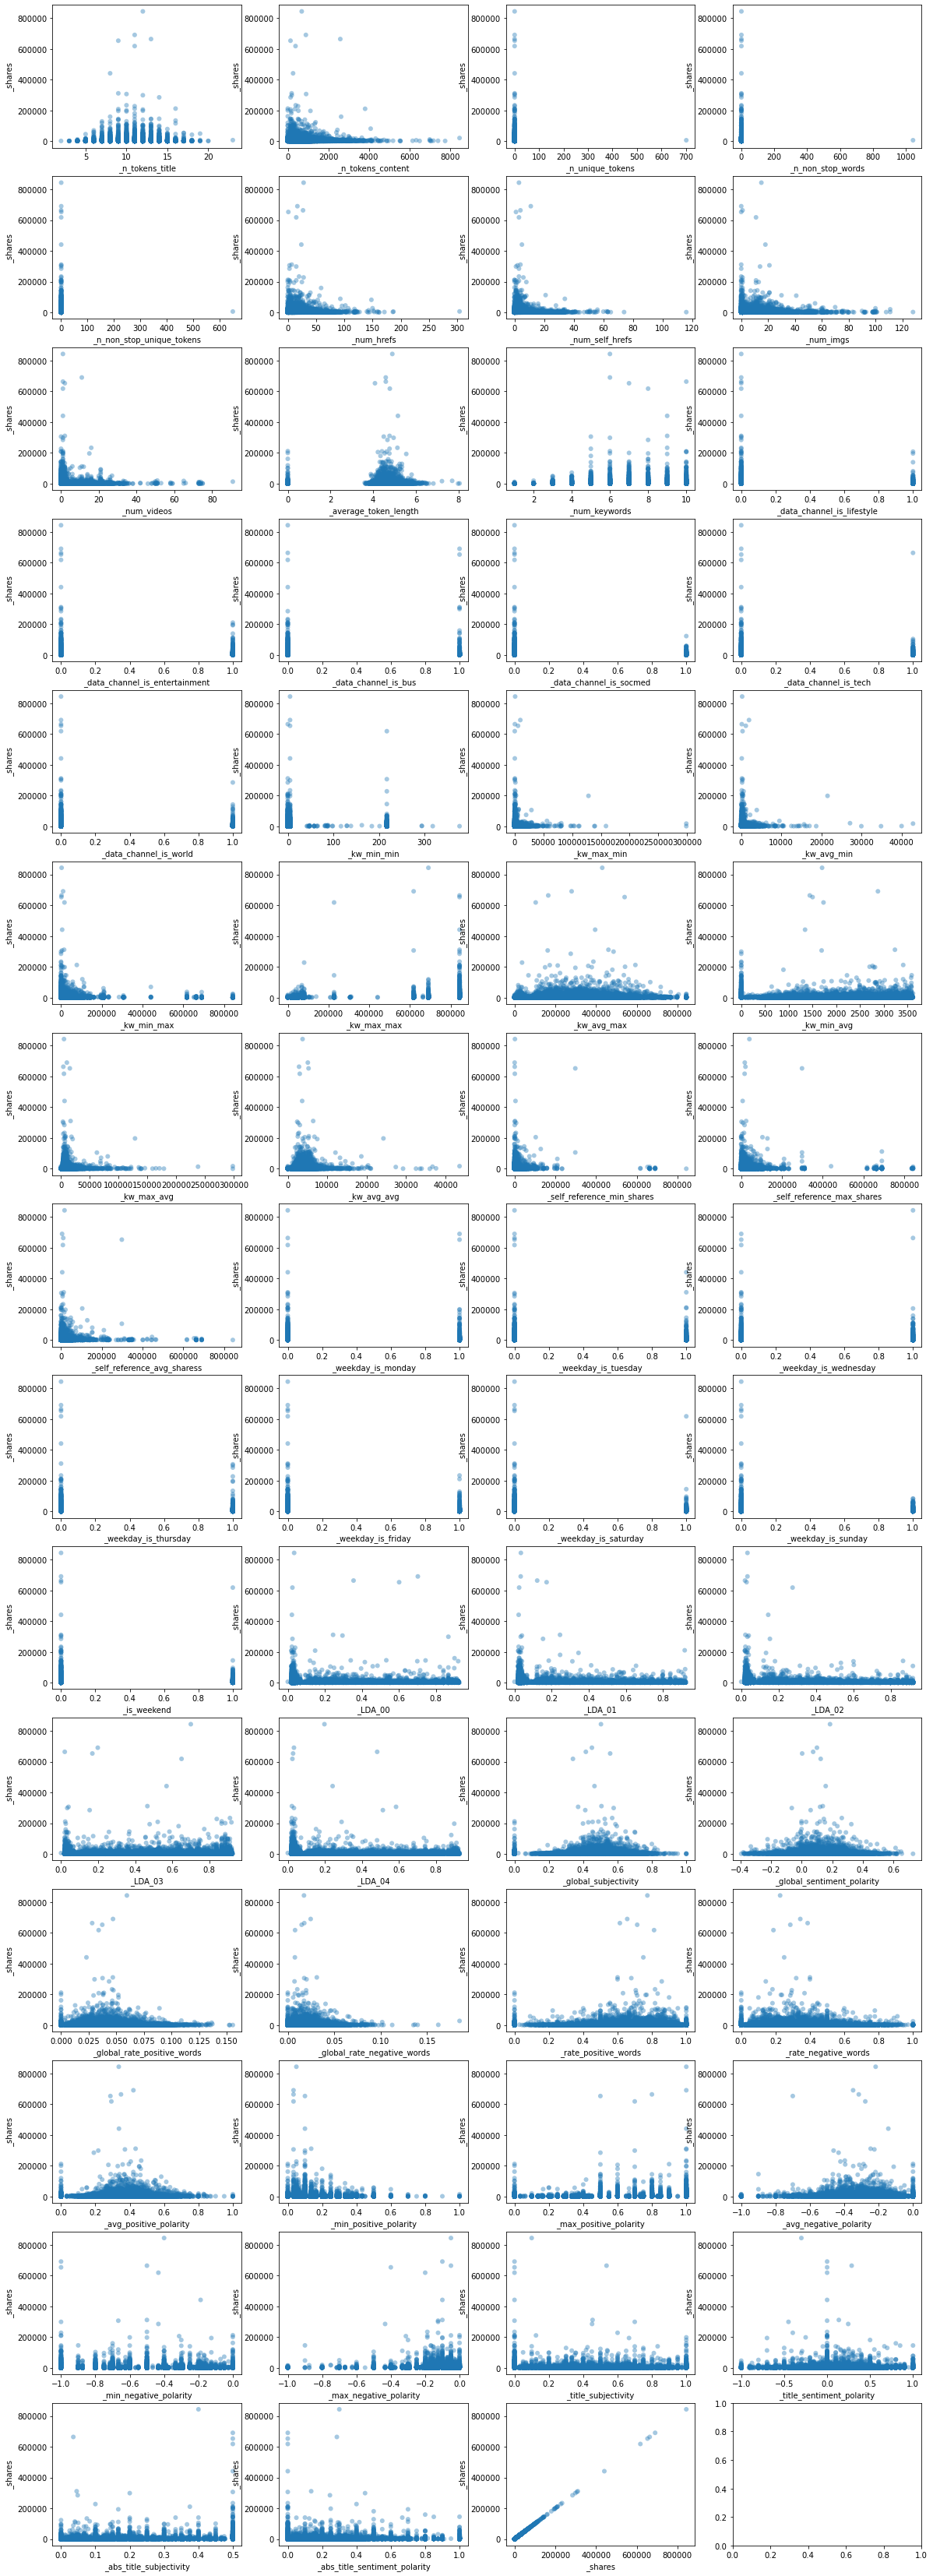

In [10]:
# Set up the figure
df_temp = df.drop(["url", "_timedelta"], axis=1)

fig, ax = plt.subplots(nrows=15, ncols=4, figsize=(20, 60))
cols = df_temp.columns
# Show each boxplot
for i, ax in enumerate(ax.flatten()):
    try:
        sns.scatterplot(x = cols[i], y = "_shares", data = df_temp, ax = ax, edgecolor='none', alpha=0.4)
        plt.xticks(cols[i])
    except:
        pass

# Show the figure
plt.show()

# Preprocessing

## Dropping irrelevant data

The two columns, "url" and "_timedelta", are not necessary for the analysis of the data set. The "URL" column contains the URLs associated with each article, which is not relevant to the analysis of the data set. The "_timedelta" column contains information about the time difference between the publication of the article and the last article published in the dataset. This is also not relevant to the analysis of the dataset.

In [11]:
df.drop(["url", "_timedelta"], axis=1, inplace=True)


## Missing values

There are no missing values in our dataset, as such the following cell does not return anything! This cell will rank the columns of our dataset from a column with the most missing values to the least.

In [12]:
data = df.isnull().mean().to_frame()
data = data[data[0] > 0].sort_values(0, ascending= False).apply(lambda x: x*100)
data.columns = ["Null Percentage"]
data.style.background_gradient("Reds")

,Null Percentage


## Dropping the outliers

Dropping outliers is a common method used to identify and remove extreme values from a dataset before analysis. This is necessary because extreme values can distort the results of the analysis, so it's important to identify and remove them first. To do this, I first illustrate the boxplot of each column to get a visual representation of their distribution. From the boxplot, I can identify any extreme values that need to be removed. Then, I apply the Isolation Forest method to detect and remove any outliers. Isolation Forest is an unsupervised learning algorithm that is used to identify outliers in a dataset by isolating them from the rest of the data points. This ensures that the outliers are removed before I conduct any further analysis.

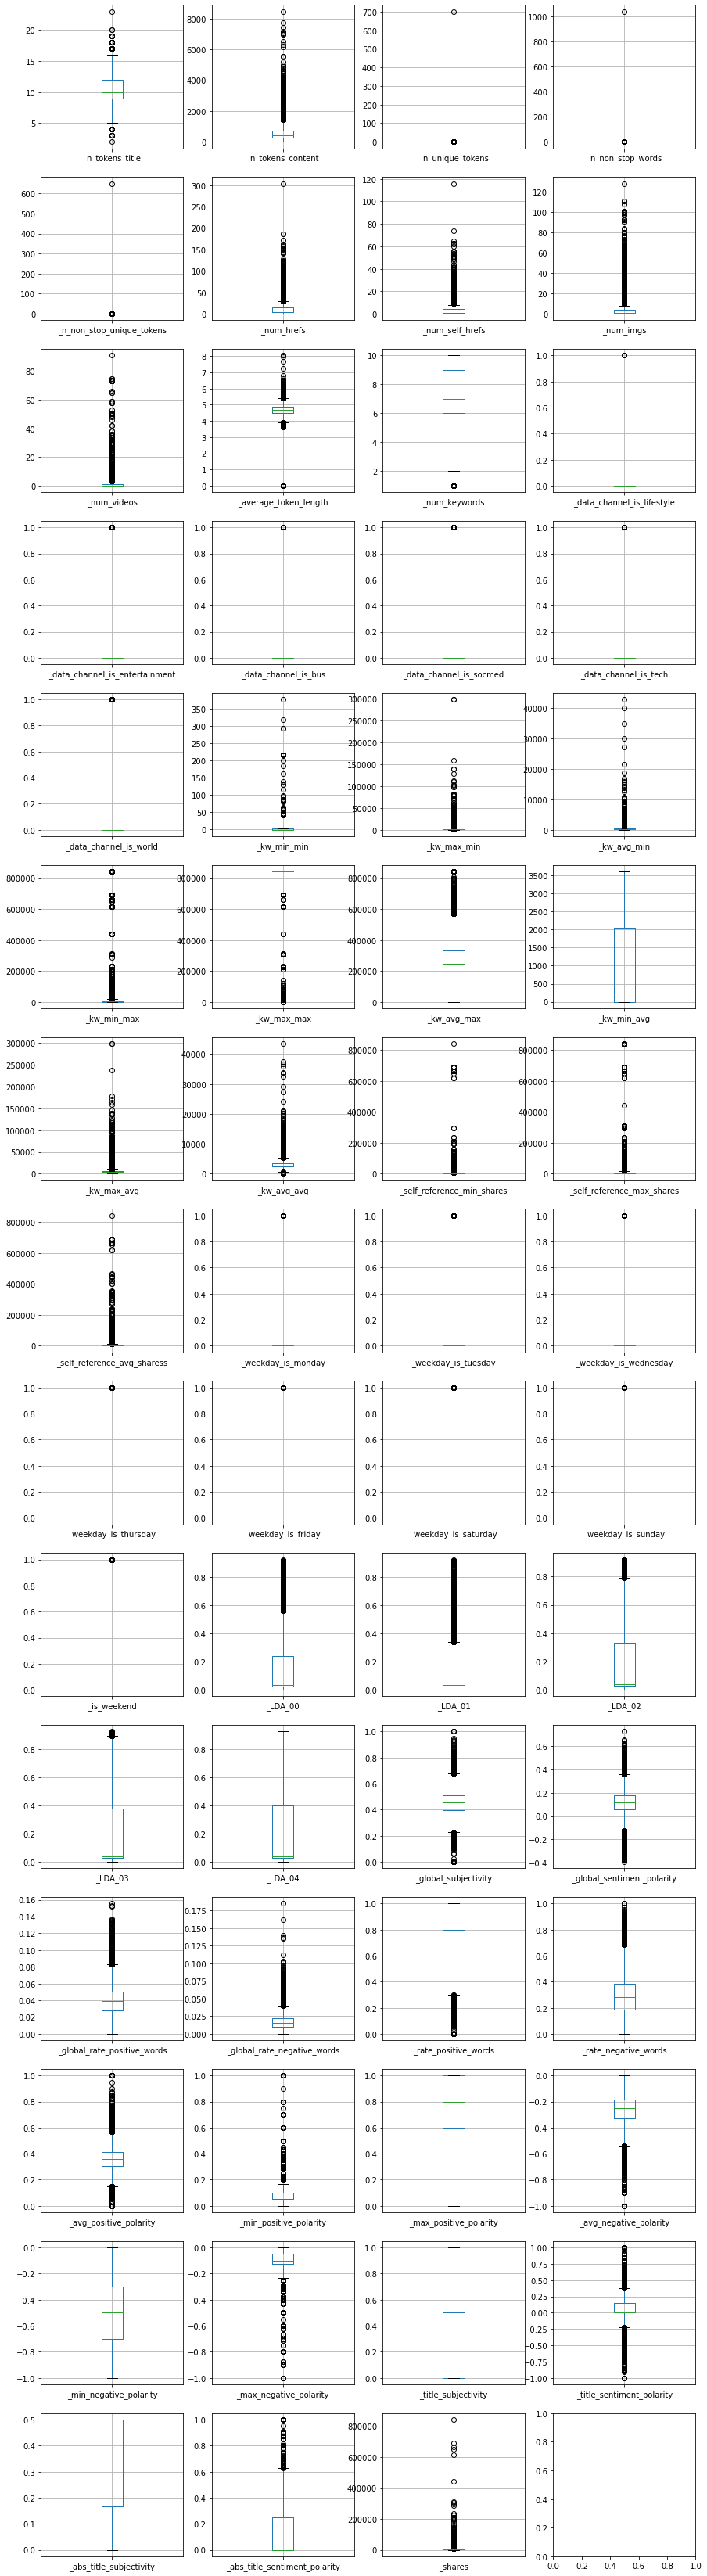

In [13]:
# Set up the figure
fig, ax = plt.subplots(nrows=15, ncols=4, figsize=(15, 60))

# Show each boxplot
for i, ax in enumerate(ax.flatten()):
    try:
        df.iloc[:,[i]].boxplot(ax=ax)
    except:
        pass

# Show the figure
plt.show()

Isolated forests are a powerful anomaly detection algorithm that can be used to identify outliers. The algorithm works by randomly selecting a subset of features from the dataset and building a decision tree around it. It then uses the decision tree to identify points that are isolated from the rest of the dataset. Due to its robustness, isolated forests are a great choice for identifying outliers in datasets with high dimensionality and complex relationships. It is also relatively easy to implement and is suitable for both online and offline applications.

In [14]:
#Train an Isolation Forest
model = IsolationForest(contamination = 0.1)
model.fit(df)

#Predict anomalies
predictions = model.predict(df)

# Get the indices of the rows with positive value in predictions
positive_indices = [i for i, x in enumerate(predictions) if x>0]

# Subset the dataframe using the indices
df_trimmed = df.iloc[positive_indices]

/Users/ali/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [15]:
df_trimmed.shape

(35679, 59)

In [16]:
df = df_trimmed

## Preparing our dataset for predictive modeling

In [17]:
y = df["_shares"]
X = df.drop("_shares", axis=1, inplace=False)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 85)

# Feature selection

Feature selection and engineering is a key technique used in machine learning, and random forests are a powerful tool for this purpose. Random forests are a type of ensemble learning technique that uses multiple decision trees to create an optimal model for prediction. The data is randomly sampled and split into separate trees, and each individual tree calculates the feature importance. This feature importance is then used to select the most important features for the model. By using random forests, models can be constructed more efficiently, with more accuracy, and with less data. Random forests are a valuable tool for feature selection and engineering, allowing users to select the most important features for their models and improve their performance.

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Create a pipeline
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', RandomForestRegressor(random_state=42))])

# Create the parameter grid
param_grid = {
    'clf__n_estimators': [10, 50, 100, 150],
    'clf__max_depth': [2, 5, 10, 15],
    'clf__min_samples_leaf': [1, 2, 4, 8],
    'clf__max_features': [2, 4, 6, 8],
}

# Create a grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit it to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best score: {}'.format(grid_search.best_score_))


Fitting 3 folds for each of 256 candidates, totalling 768 fits


/Users/ali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 

Best parameters: {'clf__max_depth': 15, 'clf__max_features': 4, 'clf__min_samples_leaf': 8, 'clf__n_estimators': 100}
Best score: 0.020312234981484118


In [21]:
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best score: {}'.format(grid_search.best_score_))

Best parameters: {'clf__max_depth': 15, 'clf__max_features': 4, 'clf__min_samples_leaf': 8, 'clf__n_estimators': 100}
Best score: 0.020312234981484118


In [81]:
# Get feature importances
importances = grid_search.best_estimator_["clf"].feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select the three most important features
features = [X.columns[i] for i in indices[:]]

In [82]:
features

['_kw_avg_avg',
 '_n_unique_tokens',
 '_self_reference_max_shares',
 '_n_non_stop_unique_tokens',
 '_self_reference_avg_sharess',
 '_self_reference_min_shares',
 '_kw_max_avg',
 '_n_tokens_content',
 '_LDA_03',
 '_global_subjectivity',
 '_avg_positive_polarity',
 '_n_non_stop_words',
 '_global_sentiment_polarity',
 '_num_hrefs',
 '_kw_avg_min',
 '_LDA_00',
 '_LDA_02',
 '_LDA_04',
 '_global_rate_positive_words',
 '_LDA_01',
 '_title_sentiment_polarity',
 '_rate_negative_words',
 '_num_imgs',
 '_global_rate_negative_words',
 '_avg_negative_polarity',
 '_kw_avg_max',
 '_abs_title_sentiment_polarity',
 '_average_token_length',
 '_kw_min_avg',
 '_rate_positive_words',
 '_kw_max_min',
 '_kw_min_max',
 '_max_negative_polarity',
 '_n_tokens_title',
 '_min_negative_polarity',
 '_abs_title_subjectivity',
 '_title_subjectivity',
 '_num_self_hrefs',
 '_min_positive_polarity',
 '_num_videos',
 '_kw_max_max',
 '_num_keywords',
 '_max_positive_polarity',
 '_kw_min_min',
 '_data_channel_is_world',
 '_

In [93]:
temp_df = pd.DataFrame({"features": features, "indices": indices, "importances": importances})
temp_df = temp_df.sort_values('importances', ascending=False).reset_index()
temp_df.style.background_gradient("Reds")

print(f"shape: {temp_df.shape}")
temp_df.head(10)

shape: (58, 4)


,index,features,indices,importances
0,25,_kw_avg_max,22,0.049973
1,2,_self_reference_max_shares,27,0.043768
2,27,_average_token_length,9,0.041204
3,4,_self_reference_avg_sharess,28,0.040969
4,28,_kw_min_avg,23,0.037862
5,26,_abs_title_sentiment_polarity,57,0.035611
6,24,_avg_negative_polarity,51,0.035462
7,1,_n_unique_tokens,2,0.034052
8,40,_kw_max_max,21,0.031656
9,42,_max_positive_polarity,50,0.030971


In [91]:
temp_df = temp_df.query('importances > 0.015')
print(f"shape: {temp_df.shape}")

shape: (32, 4)


## Cross validation

Cross validation with different alphas is a method of finding the most optimal alpha for a given model. By running a cross validation with different alphas, we can compare the performance of the model for each alpha, and the optimal alpha can be selected based on the results. This will enable us to find the best alpha for the model and thus improve the performance of the model.

In [ ]:
kf = KFold(n_splits= 10, random_state= 85, shuffle= True)
lasso_scores = {}
for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    lo = Lasso(alpha= alpha)
    cv_results = cross_val_score(lo, X_scaled, y, cv=kf)
    lasso_scores[alpha] = cv_results

/Users/ali/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e+12, tolerance: 3.211e+08
  model = cd_fast.enet_coordinate_descent(
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.357e+12, tolerance: 3.396e+08
  model = cd_fast.enet_coordinate_descent(
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

Based on the results of the following cell, we can consider an `alpha = 1` givving us the best performance in explaining the variablity in our dataset.

In [ ]:
for key, item in lasso_scores.items():
    print(f"key: {key}, mean: {np.mean(item)}")

key: 0.001, mean: 0.023150731624304987
key: 0.01, mean: 0.02315984432152912
key: 0.1, mean: 0.023237245634989745
key: 1, mean: 0.023391847788225097
key: 10, mean: 0.018405706354414197
key: 100, mean: 0.008580387017687008


Here, we are running the actual lasso model with the recommended alpha value. Following that we illustrate the coefficient of each feature using a heatmap.

In [ ]:
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

# Get coefficients
coefficients = np.round(lasso.coef_,4)

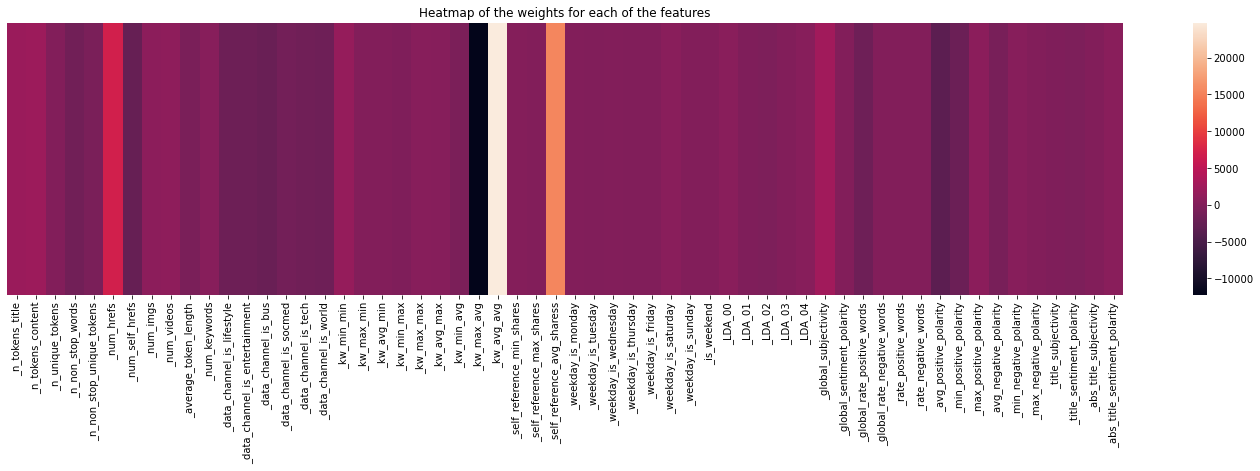

In [ ]:
plt.figure(figsize=(25, 5))
sns.heatmap(lasso.coef_.reshape(1, -1), xticklabels= X.columns, yticklabels= [])
plt.title("Heatmap of the weights for each of the features")
plt.show()

In [33]:
#applying feature selection
sfm = SelectFromModel(lasso, prefit=True)

#transforming dataset
features_new = sfm.transform(X_scaled)

#printing the selected features
print(features_new.shape)



(35679, 48)


## Ranking top 10 selected features

Feature selection is an important step in the development of any predictive model. It is useful in reducing the complexity of the model and allowing the model to focus on the most important features. By selecting the most important features, the model can be more accurate and efficient. Additionally, feature selection helps to reduce overfitting, which is when the model performs well on the training data, but not on unseen data. Feature selection helps to identify the most important features and eliminate those that are unnecessary or irrelevant. It also helps to reduce the computational cost of training the model, making it faster and more accurate.

In [34]:
# Get feature names
features = list(X.columns.values)

# Create a dataframe with feature names and coefficients
feature_coefficients = pd.DataFrame({'feature': features, 'coefficients': coefficients})

# Sort the dataframe by coefficients
sorted_features = feature_coefficients.sort_values(by='coefficients', ascending=False)

# Rank features
features_rank = sorted_features.reset_index(drop=True)

# Print feature names and their rankings
pd.DataFrame(features_rank).head(10).style.background_gradient("Reds")

,feature,coefficients
0,_kw_avg_avg,24752.223600
1,_self_reference_avg_sharess,15503.984400
2,_num_hrefs,6962.059300
3,_global_subjectivity,2604.732100
4,_n_tokens_content,2198.774200
5,_n_tokens_title,2005.098600
6,_kw_min_min,1539.813900
7,_num_videos,1043.676900
8,_num_imgs,907.492300
9,_max_positive_polarity,748.438500


In [ ]:
# Ranking negative contributions as well.

# Get feature names
features = list(X.columns.values)

# Create a dataframe with feature names and coefficients
feature_coefficients = pd.DataFrame({'feature': features, 'coefficients': coefficients})

# Sort the dataframe by coefficients
sorted_features = feature_coefficients.sort_values(by='coefficients', ascending=False)

# Rank features
features_rank = sorted_features.reset_index(drop=True)

# Print feature names and their rankings
pd.DataFrame(features_rank).head(10).style.background_gradient("Reds")

# Predictive modelling

## Linear regression

In [56]:
lr = Lasso()

X_train, X_test, y_train, y_test = train_test_split(features_new, y, shuffle= True, random_state=85)

lr.fit(X_train, y_train)

# Calculating the evaluations metrics training step
training_score_R2 = lr.score(X_train, y_train)
y_train_predicted = lr.predict(X_train)
training_score_MSE = mean_squared_error(y_train, y_train_predicted)

# Calculating the evaluations metrics testing step
testing_score_R2 = lr.score(X_test, y_test)
y_test_predicted = lr.predict(X_test)
testing_score_MSE = mean_squared_error(y_test, y_test_predicted)

print(f"Training R2 score: {training_score_R2}, MSE score: {training_score_MSE}")
print(f"Testing R2 score: {testing_score_R2}, MSE score: {testing_score_MSE}")

Training R2 score: 0.01718306542093495, MSE score: 111181728.14481063
Testing R2 score: 0.03356991232832596, MSE score: 48053519.99060277


In [36]:
kf = KFold(n_splits= 10, random_state= 85, shuffle= True)

lr = LinearRegression()
lr_results_R2 = cross_val_score(lr, features_new, y, cv=kf)
lr_results_mse = cross_val_score(lr, features_new, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean
print(f"mean R2: {np.mean(list(lr_results_R2))}")
print(f"mean MSE: {np.mean(list(lr_results_mse))}")

# Print the standard deviation
print(f"std R2: {np.std(list(lr_results_R2))}")
print(f"std MSE: {np.std(list(lr_results_mse))}")

# Print the 95% confidence interval
print(f"95 percent confidence interval R2: {np.quantile(list(lr_results_R2), [0.025, 0.975])}")
print(f"95 percent confidence interval MSE: {np.quantile(list(lr_results_mse), [0.025, 0.975])}")

mean R2: 0.023653957549341197
mean MSE: -95638372.93143469
std R2: 0.012059768127026298
std MSE: 67074133.07907241
95 percent confidence interval R2: [0.00820413 0.03938797]
95 percent confidence interval MSE: [-2.15526450e+08 -2.27189666e+07]


## Random forests

In [48]:
rf = RandomForestRegressor(1000)

X_train, X_test, y_train, y_test = train_test_split(features_new, y, shuffle= True, random_state= 85, test_size=0.2)

rf.fit(X_train, y_train)

# Calculating the evaluations metrics training step
training_score_R2 = rf.score(X_train, y_train)
y_train_predicted = rf.predict(X_train)
training_score_MSE = mean_squared_error(y_train, y_train_predicted)

# Calculating the evaluations metrics testing step
testing_score_R2 = rf.score(X_test, y_test)
y_test_predicted = rf.predict(X_test)
testing_score_MSE = mean_squared_error(y_test, y_test_predicted)

print(f"Training R2 score: {training_score_R2}, MSE score: {training_score_MSE}")
print(f"Testing R2 score: {testing_score_R2}, MSE score: {testing_score_MSE}")

Training R2 score: 0.8607965016121739, MSE score: 15299561.632825425
Testing R2 score: -0.1728125361632713, MSE score: 54821303.522124864


In [37]:
kf = KFold(n_splits= 5, random_state= 85, shuffle= True)

rf = RandomForestRegressor(100)
rf_results_R2 = cross_val_score(rf, features_new, y, cv=kf)
rf_results_mse = cross_val_score(rf, features_new, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean
print(f"mean R2: {np.mean(list(rf_results_R2))}")
print(f"mean MSE: {np.mean(list(rf_results_mse))}")

# Print the standard deviation
print(f"std R2: {np.std(list(rf_results_R2))}")
print(f"std MSE: {np.std(list(rf_results_mse))}")

# Print the 95% confidence interval
print(f"95 percent confidence interval R2: {np.quantile(list(rf_results_R2), [0.025, 0.975])}")
print(f"95 percent confidence interval MSE: {np.quantile(list(rf_results_mse), [0.025, 0.975])}")

mean R2: -0.07428648186058373
mean MSE: -101822965.59240282
std R2: 0.07421356999815414
std MSE: 47135106.8584811
95 percent confidence interval R2: [-0.19800378 -0.0147491 ]
95 percent confidence interval MSE: [-1.71378101e+08 -4.64043720e+07]


In [65]:
selected_features = feature_coefficients[feature_coefficients["coefficients"] != 0].feature.values

In [66]:
new_df = pd.DataFrame(features_new, columns= selected_features)

In [76]:
#get 25th, 50th and 75th percentile
q25 = y.quantile(q = 0.25)
q50 = y.quantile(q = 0.50)
q75 = y.quantile(q = 0.75)
q100 = y.quantile(q = 1)

In [140]:
y_classification = pd.DataFrame(columns=["class"])

for index, row in pd.DataFrame(y).iterrows():
    # if row["_shares"] < q25:
    #     y_classification.loc[index, "class"] = "*"
    # elif row["_shares"] >= q25 and row["_shares"] < q50:
    #     y_classification.loc[index, "class"] = "**"
    # elif row["_shares"] >= q50 and row["_shares"] < q75:
    #     y_classification.loc[index, "class"] = "***"
    # else:
    #     y_classification.loc[index, "class"] = "****"
    
    if row["_shares"] < q50:
        y_classification.loc[index, "class"] = "*"
    else:
        y_classification.loc[index, "class"] = "****"



In [141]:
rfc = RandomForestClassifier(100)

X_train, X_test, y_train, y_test = train_test_split(new_df, y_classification["class"], stratify= y_classification["class"], shuffle=True, test_size= 0.2, random_state=85)

rfc.fit(X_train, y_train)


RandomForestClassifier()

In [142]:
y_predicted = rfc.predict(X_test)

In [143]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           *       0.65      0.63      0.64      3410
        ****       0.67      0.69      0.68      3726

    accuracy                           0.67      7136
   macro avg       0.66      0.66      0.66      7136
weighted avg       0.67      0.67      0.67      7136



In [144]:
import xgboost

In [145]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [152]:
# Create XGBoost classifier object
xgb_clf = xgboost.XGBClassifier(colsample_bytree= 0.5, n_estimators=10, max_depth = 5)

# Fit the classifier with the training data
xgb_clf.fit(X_train, y_train)

# Make predictions using the testing data
predictions = xgb_clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64      3410
           1       0.67      0.70      0.69      3726

    accuracy                           0.67      7136
   macro avg       0.67      0.66      0.66      7136
weighted avg       0.67      0.67      0.67      7136



In [153]:
xgb_clf.score(X_test, y_test)

0.6661995515695067

In [154]:
xgb_clf.score(X_train, y_train)

0.6864730406754721

In [204]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y_classification["class"], stratify= y_classification["class"], shuffle=True, test_size= 0.2, random_state=85)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [ ]:
x_train

In [238]:
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit

# Create a model using the first regression
formula = 'y_train ~ ' + ' + '.join([col for col in X_train.columns if col != '_data_channel_is_lifestyle'])
model1 = ols(formula, data=X_train).fit()

# Create a model using the second regression
formula = 'y_train ~ ' + ' + '.join(X_train.columns)
model2 = ols(formula, data=X_train).fit()

# Run an ANOVA test
anova_table = sm.stats.anova_lm(model1, model2)
print(anova_table)

   df_resid          ssr  df_diff   ss_diff        F    Pr(>F)
0   28496.0  6198.249078      0.0       NaN      NaN       NaN
1   28495.0  6198.245082      1.0  0.003996  0.01837  0.892189


In [236]:
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit

# Create a model using the first regression
formula = 'y_train ~ ' + ' + '.join([col for col in X_train.columns if col != '_data_channel_is_entertainment'])
model1 = ols(formula, data=X_train).fit()

# Create a model using the second regression
formula = 'y_train ~ ' + ' + '.join(X_train.columns)
model2 = ols(formula, data=X_train).fit()

# Run an ANOVA test
anova_table = sm.stats.anova_lm(model1, model2)
print(anova_table)

   df_resid          ssr  df_diff   ss_diff          F    Pr(>F)
0   28496.0  6203.144981      0.0       NaN        NaN       NaN
1   28495.0  6198.245082      1.0  4.899899  22.526154  0.000002


In [242]:
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
import scipy.stats as stats

# Create a model using the first regression
formula = 'y_train ~ ' + ' + '.join([col for col in X_train.columns if col != '_data_channel_is_entertainment'])
model1 = ols(formula, data=X_train).fit()

# Create a model using the second regression
formula = 'y_train ~ ' + ' + '.join([col for col in X_train.columns if col != '_data_channel_is_lifestyle'])
model2 = ols(formula, data=X_train).fit()

# Run an ANOVA test
anova_table = sm.stats.anova_lm(model1, model2)
print(anova_table)

   df_resid          ssr  df_diff   ss_diff    F  Pr(>F)
0   28496.0  6203.144981      0.0       NaN  NaN     NaN
1   28496.0  6198.249078     -0.0  4.895903 -inf     NaN


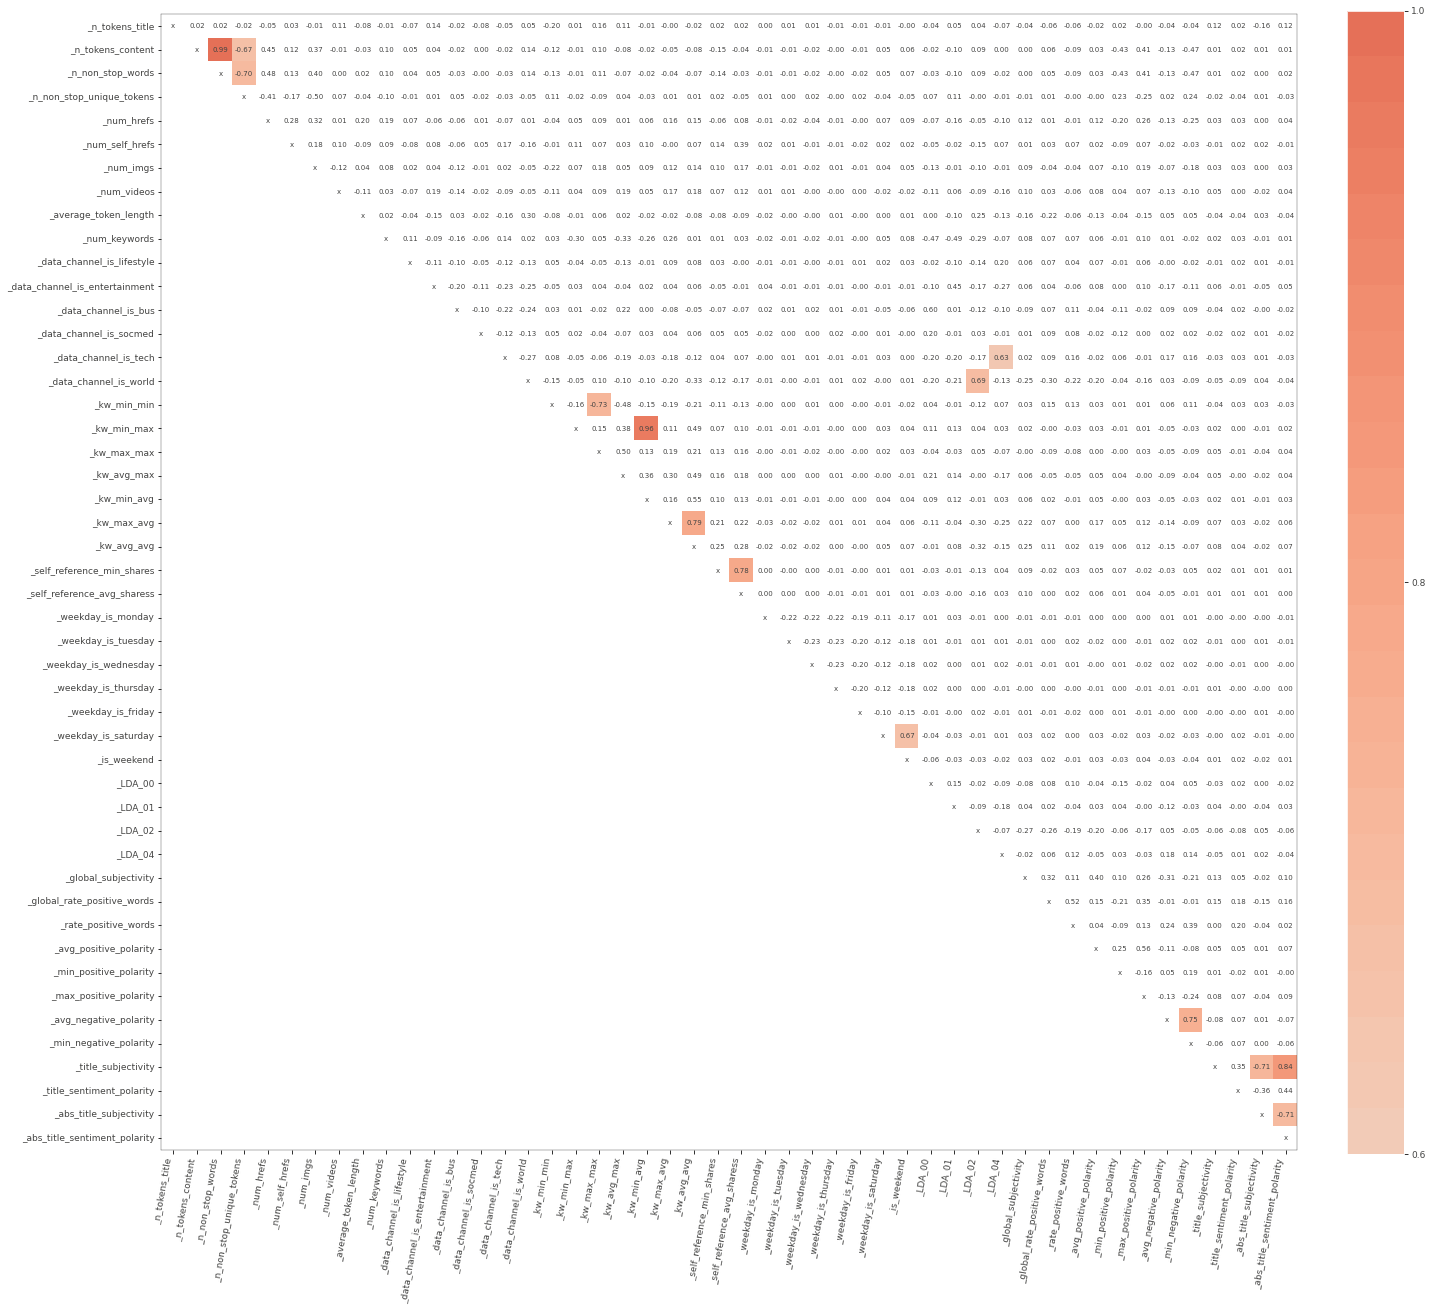

In [234]:
# Plot the correlation between each
from rfpimp import plot_corr_heatmap
corr = plot_corr_heatmap(X_train, figsize=(20, 20), label_fontsize=9, value_fontsize=7)  # from rfpimp package

# Takeaways
1. Random forests in general have been able to explain the varibility in our data better than linear regression
2. Neither of the two models are successful in predicting the number of shares `shares`
3. Perhaps solving this problem as a classification problem would provide more meaningful insights